In [66]:
# importing libraries

import plotly.express as px
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# setting randoms state
tf.random.set_seed(42)

# Training

In [67]:
# Time series to LSTM data
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df.to_numpy()


In [68]:
# reading data
df_train = pd.read_csv('data_9hr.csv')

# aggregatin data
df_train["datetime"] = pd.to_datetime(df_train["datetime"], format="%d/%m/%Y %H:%M")
df_train = df_train[["datetime", "ppl_out", "ppl_in"]].groupby(by="datetime").sum()
df_train["Net flow"] = df_train["ppl_in"] - df_train["ppl_out"]

pred_obj = "ppl_out"

# scaling data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(df_train[[pred_obj]])

# train-test split
train_size = int(len(scaled) * 0.8)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:,:]

# LSTM dimensions
lag = 7
train_lagged = timeseries_to_supervised(train, lag)
X, y = train_lagged[:,0:-1], train_lagged[:,-1]
X = X.reshape(X.shape[0], 1, X.shape[1])

In [69]:
# LSTM model

neurons = 32
batch_size = 1
epochs = 500

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = Sequential()
model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), activation="relu", stateful=True))
model.add(Dense(8, activation="relu"))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False, validation_split=0.33, callbacks=[callback])

Epoch 1/500
289/289 [==============================] - 1s 2ms/step - loss: 0.2017 - val_loss: 0.1317
Epoch 2/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1232 - val_loss: 0.1288
Epoch 3/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1096 - val_loss: 0.1085
Epoch 4/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0972 - val_loss: 0.1306
Epoch 5/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0923 - val_loss: 0.1136
Epoch 6/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0886 - val_loss: 0.0928
Epoch 7/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0820 - val_loss: 0.0835
Epoch 8/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0794 - val_loss: 0.0843
Epoch 9/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0739 - val_loss: 0.0780
Epoch 10/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0730 - val_lo

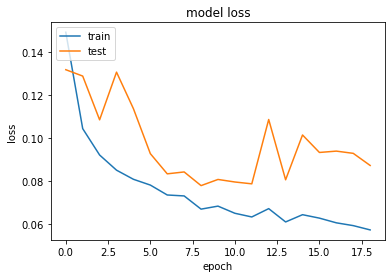

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

In [71]:
# Load trained model

saved_model = tf.keras.models.load_model('/Users/michaelkwok/Desktop/FYP/Code/APM-Dashboard/saved models')

In [72]:
saved_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (1, 32)                   5120      
_________________________________________________________________
dense_27 (Dense)             (1, 8)                    264       
_________________________________________________________________
dense_28 (Dense)             (1, 1)                    9         
Total params: 5,393
Trainable params: 5,393
Non-trainable params: 0
_________________________________________________________________


In [73]:
pred_all = timeseries_to_supervised(test, lag)
pred_X, y_true = pred_all[:,:-1], pred_all[:,-1]

pred_X_final = pred_X.reshape(pred_X.shape[0], 1, pred_X.shape[1])

y_hat = saved_model.predict(pred_X_final, batch_size=batch_size)

In [74]:
results = saved_model.evaluate(pred_X_final, y_true, batch_size=1)
results

108/108 [==============================] - 0s 1ms/step - loss: 0.0954


0.09538515657186508

In [75]:
real_y_hat = scaler.inverse_transform(y_hat)
prediction = pd.DataFrame({"pred_ppl_out":real_y_hat.reshape(len(real_y_hat))}, index=df_train[train_size:].index)

In [76]:
df_summary = pd.concat([df_train, prediction], axis=1)
df_summary["ppl_out"] = df_summary["ppl_out"][:train_size]
df_summary

,ppl_out,ppl_in,Net flow,pred_ppl_out
datetime,,,,
2023-03-27 09:00:00,15.0,14,-1,NaN
2023-03-27 09:01:00,15.0,14,-1,NaN
2023-03-27 09:02:00,4.0,5,1,NaN
2023-03-27 09:03:00,12.0,14,2,NaN
2023-03-27 09:04:00,19.0,17,-2,NaN
...,...,...,...,...
2023-03-27 17:55:00,NaN,13,2,7.611064
2023-03-27 17:56:00,NaN,13,6,7.608193
2023-03-27 17:57:00,NaN,16,4,15.280403


In [77]:
fig = px.line(df_summary[["ppl_out", "pred_ppl_out"]], title="Prediction and raw data plot (Outflow)")
fig.update_xaxes(title="Time")
fig.update_yaxes(title="People outflow")

# Ppl in section

In [78]:
pred_obj = "ppl_in"

# scaling data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(df_train[[pred_obj]])

# train-test split
train_size = int(len(scaled) * 0.8)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:,:]

# LSTM dimensions
lag = 7
train_lagged = timeseries_to_supervised(train, lag)
X, y = train_lagged[:,0:-1], train_lagged[:,-1]
X = X.reshape(X.shape[0], 1, X.shape[1])

In [79]:
# LSTM model

neurons = 32
batch_size = 1
epochs = 500

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = Sequential()
model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), activation="relu", stateful=True))
model.add(Dense(8, activation="relu"))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False, validation_split=0.33, callbacks=[callback])

Epoch 1/500
289/289 [==============================] - 1s 2ms/step - loss: 0.1662 - val_loss: 0.1131
Epoch 2/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1333 - val_loss: 0.0976
Epoch 3/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1238 - val_loss: 0.0989
Epoch 4/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1175 - val_loss: 0.0942
Epoch 5/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1140 - val_loss: 0.0972
Epoch 6/500
289/289 [==============================] - 0s 2ms/step - loss: 0.1094 - val_loss: 0.1002
Epoch 7/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1054 - val_loss: 0.0893
Epoch 8/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1025 - val_loss: 0.0947
Epoch 9/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1005 - val_loss: 0.0889
Epoch 10/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0935 - val_lo

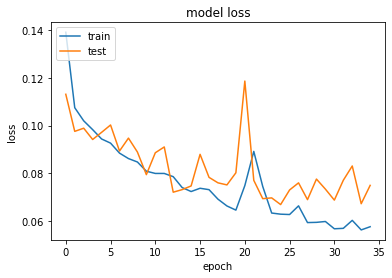

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

In [81]:
# Load trained model

saved_model = tf.keras.models.load_model('/Users/michaelkwok/Desktop/FYP/Code/APM-Dashboard/saved models (inflow)')

In [82]:
saved_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (1, 32)                   5120      
_________________________________________________________________
dense_14 (Dense)             (1, 8)                    264       
_________________________________________________________________
dense_15 (Dense)             (1, 1)                    9         
Total params: 5,393
Trainable params: 5,393
Non-trainable params: 0
_________________________________________________________________


In [83]:
pred_all = timeseries_to_supervised(test, lag)
pred_X, y_true = pred_all[:,:-1], pred_all[:,-1]

pred_X_final = pred_X.reshape(pred_X.shape[0], 1, pred_X.shape[1])

y_hat_in = saved_model.predict(pred_X_final, batch_size=batch_size)

In [84]:
real_y_hat_in = scaler.inverse_transform(y_hat_in)
prediction = pd.DataFrame({"pred_ppl_in":real_y_hat_in.reshape(len(real_y_hat))}, index=df_train[train_size:].index)

In [85]:
df_summary = pd.concat([df_train, prediction], axis=1)
df_summary["ppl_in"] = df_summary["ppl_in"][:train_size]
df_summary

,ppl_out,ppl_in,Net flow,pred_ppl_in
datetime,,,,
2023-03-27 09:00:00,15,14.0,-1,NaN
2023-03-27 09:01:00,15,14.0,-1,NaN
2023-03-27 09:02:00,4,5.0,1,NaN
2023-03-27 09:03:00,12,14.0,2,NaN
2023-03-27 09:04:00,19,17.0,-2,NaN
...,...,...,...,...
2023-03-27 17:55:00,11,NaN,2,14.461008
2023-03-27 17:56:00,7,NaN,6,14.665571
2023-03-27 17:57:00,12,NaN,4,15.676683


In [86]:
fig = px.line(df_summary[["ppl_in", "pred_ppl_in"]], title="Prediction and raw data plot (Inflow)")
fig.update_xaxes(title="Time")
fig.update_yaxes(title="People outflow")